# Importing Required Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Multi GPU strategy with TensorFlow

In [2]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 2


In [3]:
PATH = '/kaggle/input/dog-breed-identification'
NUM_CHANNEL = 3
INPUT_SHAPE = 256
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Data Preprocessing

ImageDatastore to read files and feeds into the model during training

In [4]:
class ImageDatastore:
    
    def __init__(self, path, csv, output_shape, train_val_test):
        self.path = path
        self.csv = csv
        self.output_shape = output_shape
        self.train_val_test = train_val_test
        self.image_paths, self.labels = self.get_files_and_labels()
        
    def get_files_and_labels(self):
        image_paths = [os.path.join(self.path, path) + '.jpg' for path in self.csv.index]
        if self.train_val_test == 'test':
            labels = ['' for i in range(len(image_paths))]
        else:
            labels = pd.get_dummies(self.csv.breed).astype('uint8').to_numpy()
        return image_paths, labels
    
    def __call__(self):
        pairs = list(zip(self.image_paths, self.labels))
        for image_path, label in pairs:
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.output_shape)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.train_val_test == 'test':
                yield image
            else:
                yield image, label

CustomCallback to patiently reduce the learning rate, then stops at the last patience.

In [5]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor="loss", factor=0.5, patience=0, min_lr=0.01):
        super(CustomCallback, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.job = 0

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        if 'loss' in self.monitor:
            self.best = np.inf
        else:
            self.best = -1

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if 'loss' in self.monitor and current < self.best:
            self.best = current
            self.wait = 0
        elif 'acc' in self.monitor and  current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.job == 0:
                    lr = float(K.get_value(self.model.optimizer.learning_rate))
                    new_lr = lr * self.factor
                    if new_lr < self.min_lr:
                        new_lr = self.min_lr
                        self.job = 1
                    K.set_value(self.model.optimizer.lr, new_lr)
                    self.wait = 0
                    print(f"\nLearning rate reduced from {'{:.3g}'.format(lr)} to {'{:.3g}'.format(new_lr)}")
                elif self.job == 1:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")

In [6]:
train_df = pd.read_csv(os.path.join(PATH, 'labels.csv'), index_col='id')
train_df.head()

breed
id                                                
000bec180eb18c7604dcecc8fe0dba07       boston_bull
001513dfcb2ffafc82cccf4d8bbaba97             dingo
001cdf01b096e06d78e9e5112d419397          pekinese
00214f311d5d2247d5dfe4fe24b2303d          bluetick
0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

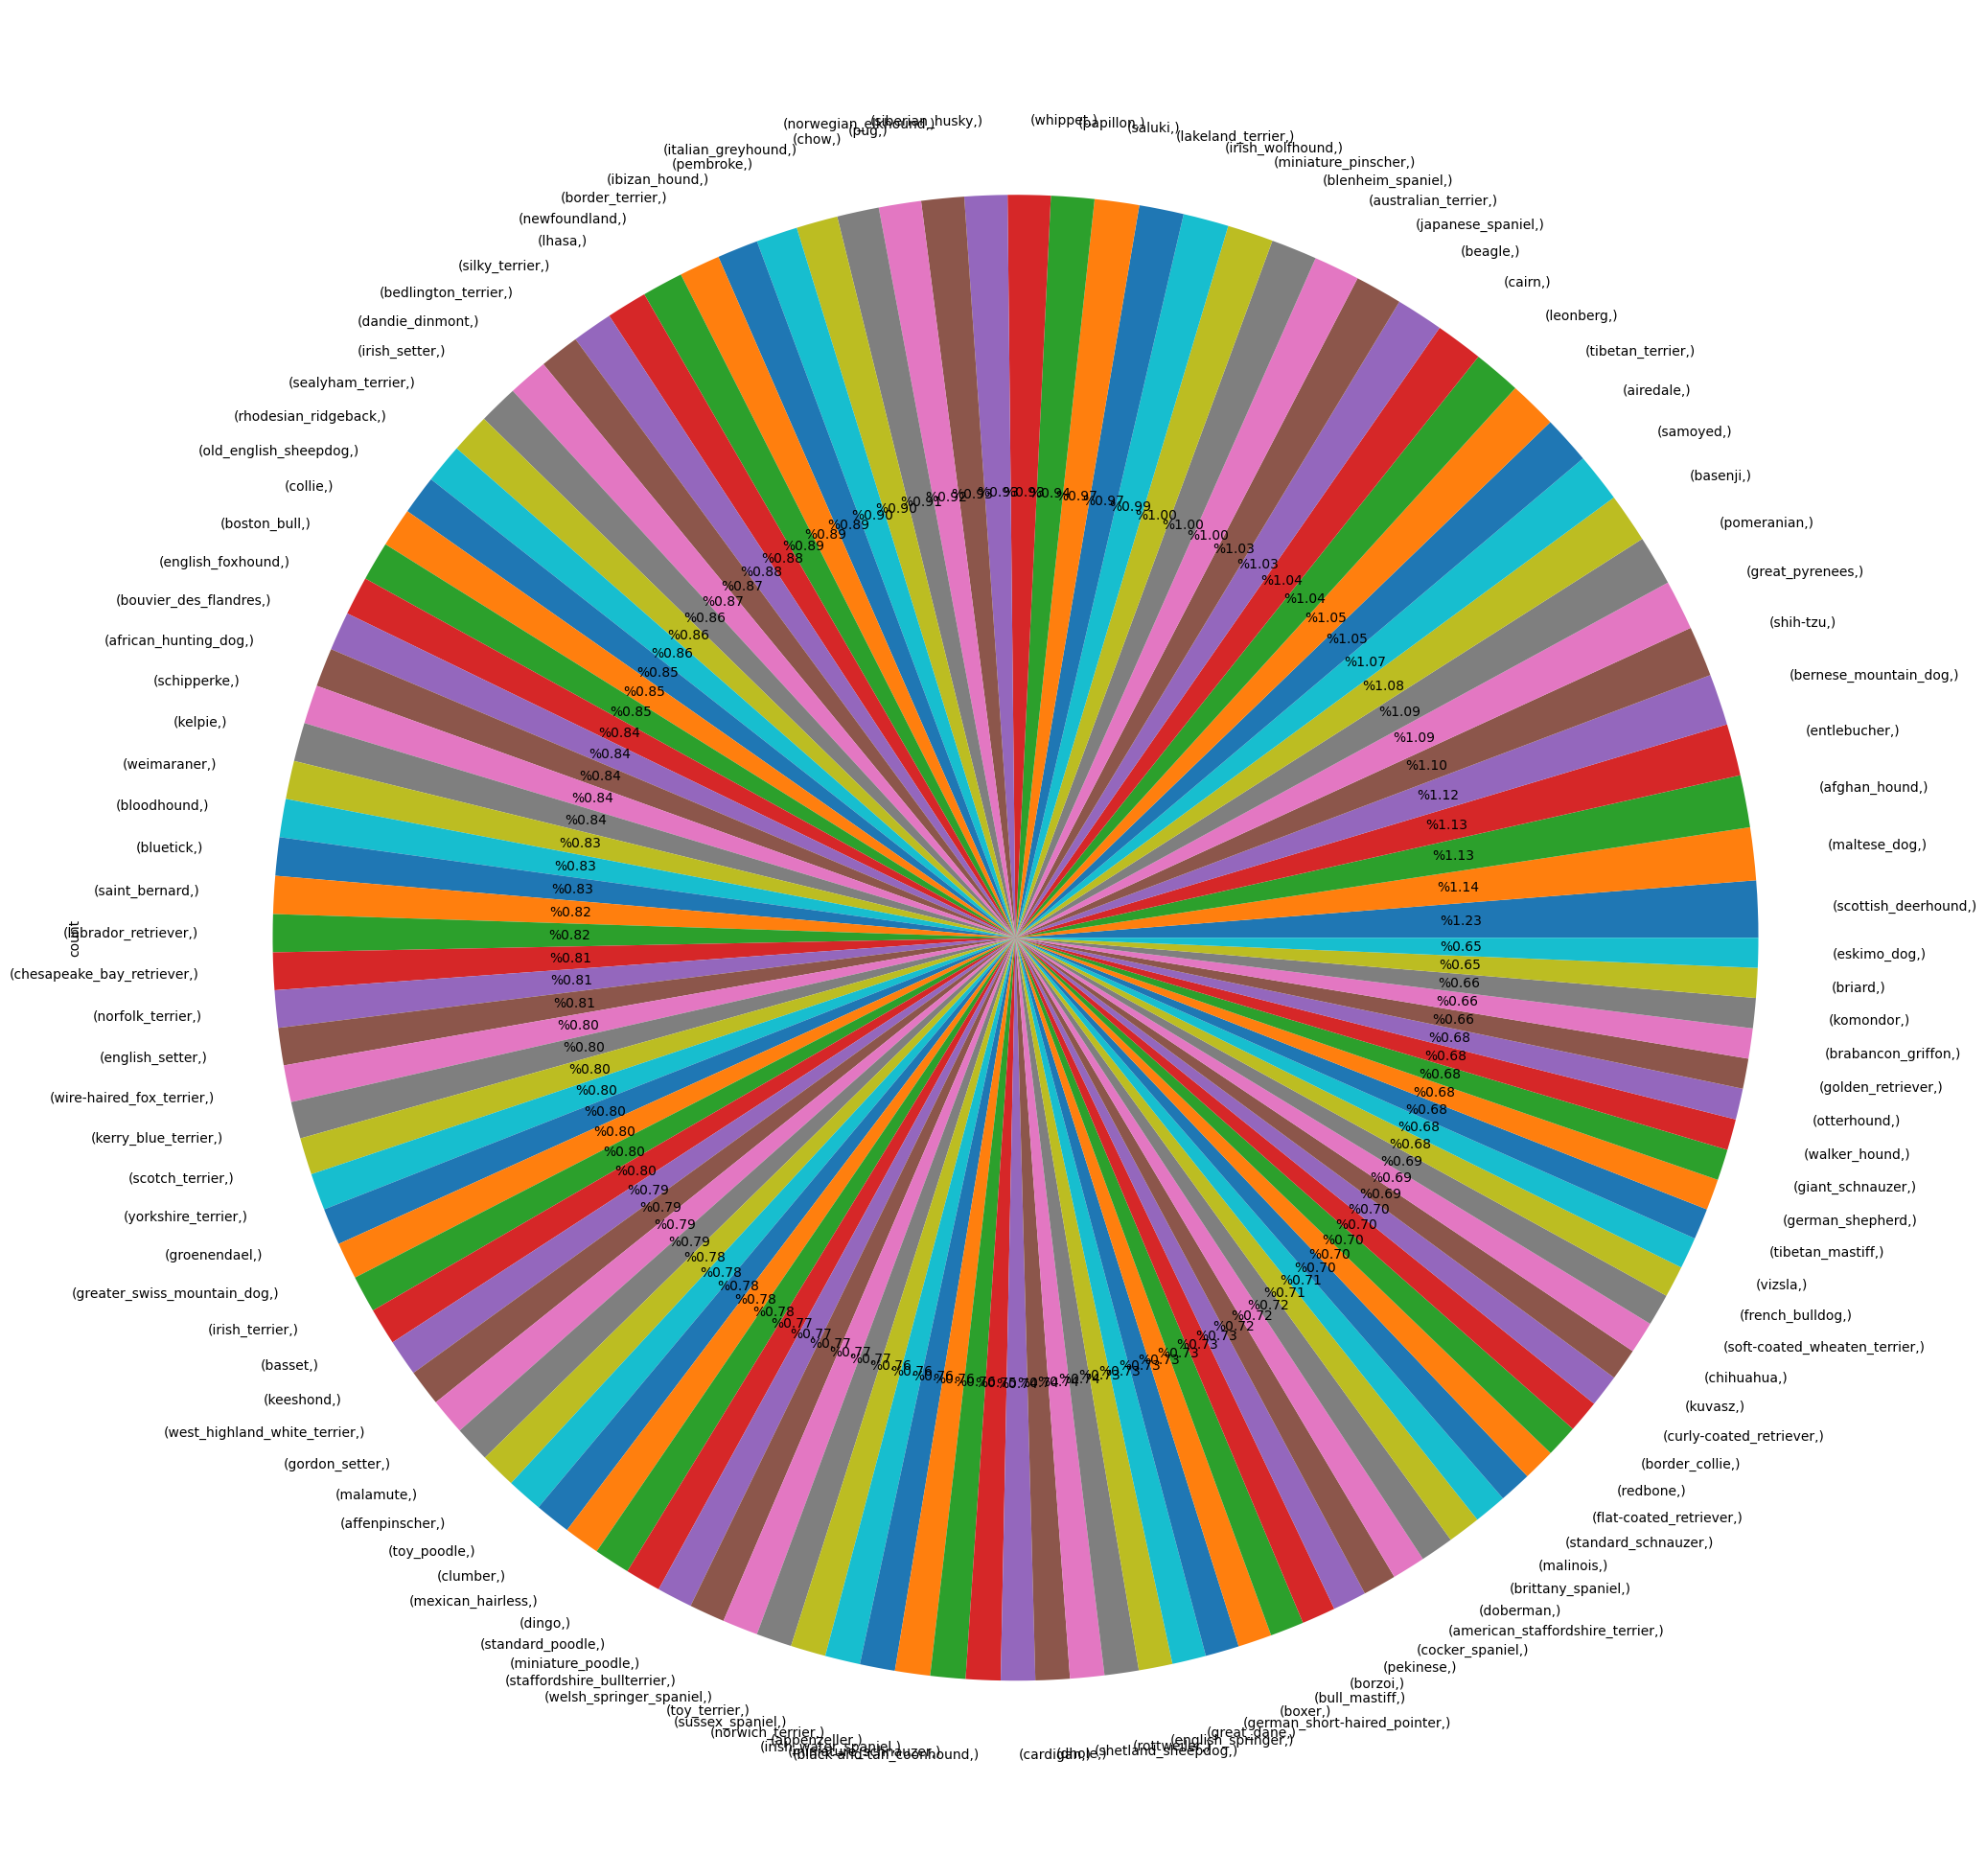

In [7]:
train_df.value_counts().plot.pie(autopct='%%%.2f', figsize=(25, 50));

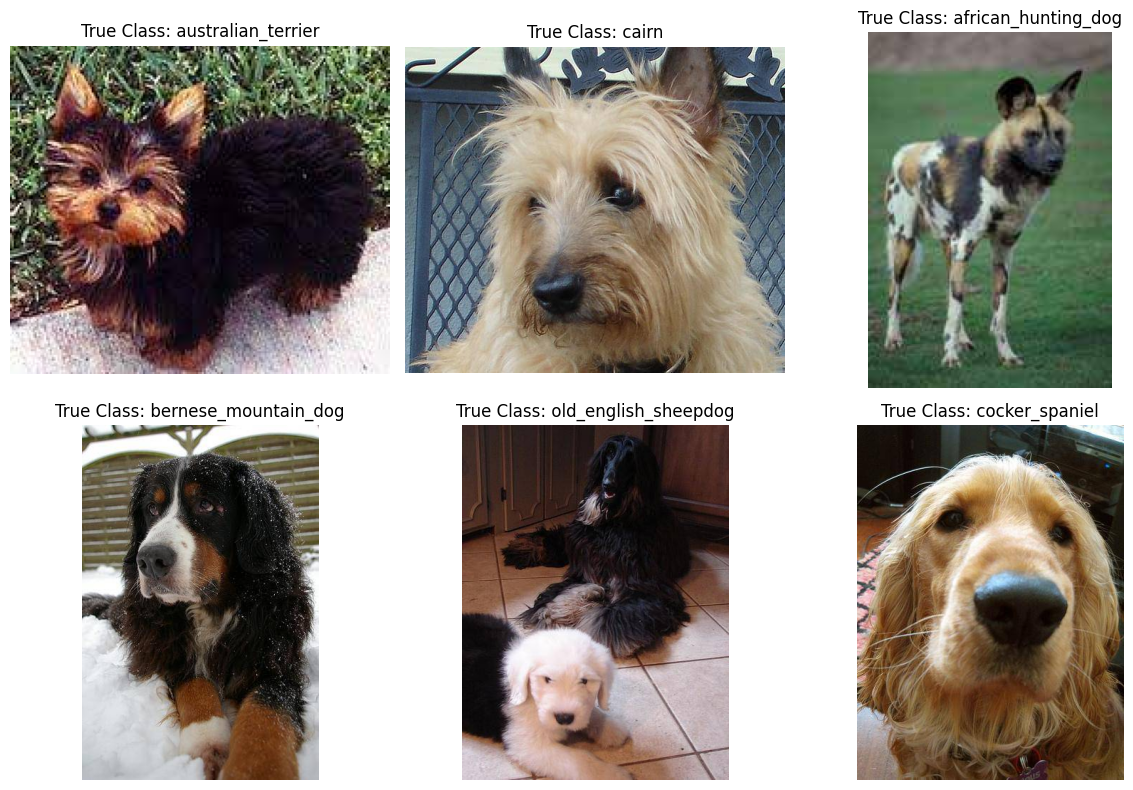

In [8]:
samples = train_df.sample(6)
plt.figure(figsize=(12, 8))

for i, index in enumerate(samples.index):
    plt.subplot(230 + i + 1)
    img = mpimg.imread(os.path.join(PATH, 'train', index + '.jpg'))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True Class: {samples.loc[[index], "breed"].values[0]}')
    
plt.tight_layout()
plt.show()

In [9]:
NUM_CLASS = train_df.breed.nunique()
print(f'Number of classes: {NUM_CLASS}')

Number of classes: 120


In [10]:
val_ratio = 0.2
num_sapmle = int(len(train_df) * val_ratio / NUM_CLASS)

In [11]:
val_df = pd.concat([train_df[train_df.breed == lbl].sample(num_sapmle) for lbl in train_df.breed.unique()], axis=0)
val_df = val_df.sample(frac=1)

train_df = train_df.drop(val_df.index)

In [12]:
print(f'''Number of train images: {len(train_df)}
Number of val images: {len(val_df)}''')

Number of train images: 8182
Number of val images: 2040


In [13]:
train_ds = ImageDatastore(os.path.join(PATH, 'train'), train_df, (INPUT_SHAPE, INPUT_SHAPE), 'train')
val_ds = ImageDatastore(os.path.join(PATH, 'train'), val_df, (INPUT_SHAPE, INPUT_SHAPE), 'val')

Data augmentation with random flip, rotation and zoom. 

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

tf.Data for [better performance](https://www.tensorflow.org/guide/data_performance)  

In [15]:
OUTPUT_SIGNATURE = (tf.TensorSpec(shape=(INPUT_SHAPE, INPUT_SHAPE, NUM_CHANNEL), dtype='uint8'), tf.TensorSpec(shape=(NUM_CLASS), dtype='uint8'))

train = tf.data.Dataset.from_generator(generator=train_ds, output_signature=OUTPUT_SIGNATURE)
train = tf.data.Dataset.range(1).interleave(lambda _: train, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=True).map(lambda X, y: (data_augmentation(X, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val = tf.data.Dataset.from_generator(generator=val_ds, output_signature=OUTPUT_SIGNATURE)
val = tf.data.Dataset.range(1).interleave(lambda _: val, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Building a Model

Method to build model with hyper-parameters optimization features

In [16]:
def build_model(hp):

    input_shape = (INPUT_SHAPE, INPUT_SHAPE, NUM_CHANNEL)

    base = tf.keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
    base.trainable=False
    base.training=False

    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x)
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x=tf.keras.layers.Dense(hp_units)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    hp_act = hp.Choice('activation', values=['relu', 'tanh'])
    x=tf.keras.layers.Activation(hp_act)(x)
    
    hp_drop = hp.Float('rate', min_value=0.0, max_value=0.5, step=0.1)
    x=tf.keras.layers.Dropout(hp_drop)(x)
    
    outputs = tf.keras.layers.Dense(NUM_CLASS, activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
    )
    return model

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    distribution_strategy=strategy)

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
tuner.search(train, epochs=10, validation_data=val)

Trial 30 Complete [00h 01m 47s]
val_accuracy: 0.7752016186714172

Best val_accuracy So Far: 0.7857862710952759
Total elapsed time: 00h 28m 35s


In [19]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is {best_hps.get('units')}.
The optimal activation for the first densely-connected is {best_hps.get('activation')}.
The optimal rate for dropout is {best_hps.get('rate')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 288.
The optimal activation for the first densely-connected is tanh.
The optimal rate for dropout is 0.30000000000000004.



Create the model with best hyper-parameters

In [20]:
with strategy.scope():
    model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_2 (Dense)             (None, 288)               368928    
                                                           

In [21]:
history = model.fit(
    train,
    epochs=1000,
    validation_data=val,
    callbacks=[CustomCallback(monitor='val_accuracy', factor=0.5, patience=10, min_lr=2e-6)]
)

Epoch 1/1000
127/127 [==============================] - 19s 89ms/step - loss: 3.0219 - accuracy: 0.3098 - val_loss: 1.2406 - val_accuracy: 0.7253
Epoch 2/1000
127/127 [==============================] - 9s 69ms/step - loss: 1.6245 - accuracy: 0.5945 - val_loss: 0.8869 - val_accuracy: 0.7762
Epoch 3/1000
127/127 [==============================] - 9s 69ms/step - loss: 1.1725 - accuracy: 0.7119 - val_loss: 0.7971 - val_accuracy: 0.7818
Epoch 4/1000
127/127 [==============================] - 9s 69ms/step - loss: 0.8535 - accuracy: 0.8013 - val_loss: 0.7764 - val_accuracy: 0.7828
Epoch 5/1000
127/127 [==============================] - 9s 69ms/step - loss: 0.6033 - accuracy: 0.8804 - val_loss: 0.7698 - val_accuracy: 0.7702
Epoch 6/1000
127/127 [==============================] - 9s 68ms/step - loss: 0.4218 - accuracy: 0.9327 - val_loss: 0.7700 - val_accuracy: 0.7616
Epoch 7/1000
127/127 [==============================] - 9s 67ms/step - loss: 0.2822 - accuracy: 0.9649 - val_loss: 0.7651 - val_a

Plotting metrics

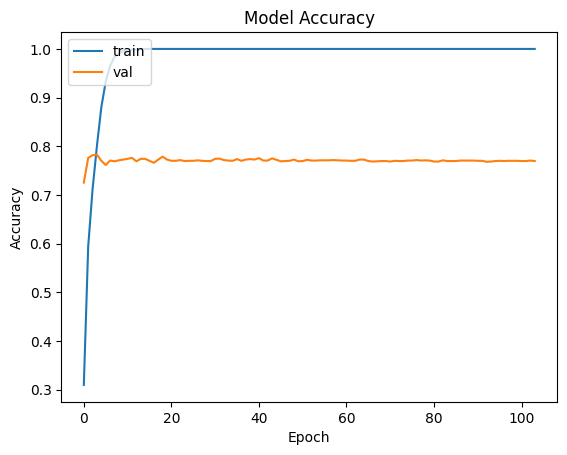

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

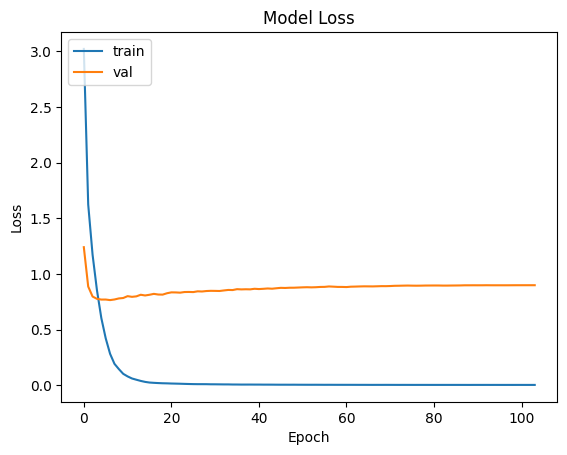

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction

In [24]:
classes = sorted(train_df.breed.unique())
print(classes)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

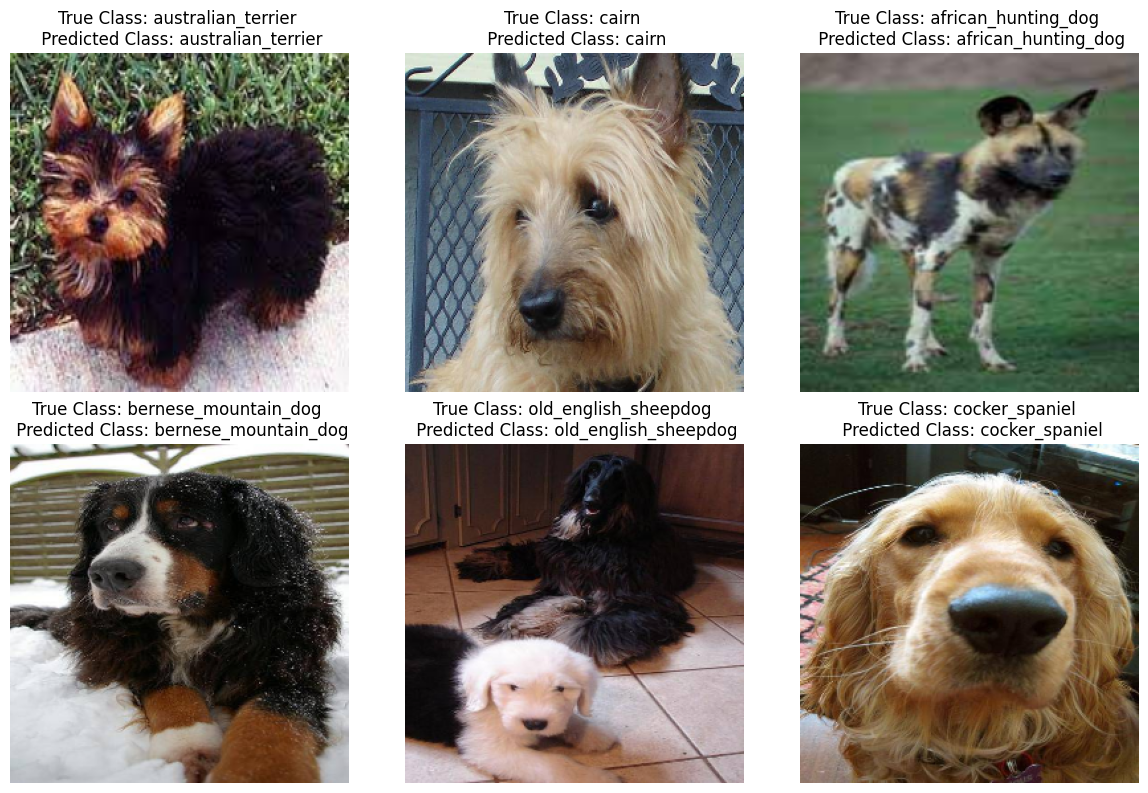

In [25]:
plt.figure(figsize=(12, 8))

for i, index in enumerate(samples.index):
    img = mpimg.imread(os.path.join(PATH, 'train', index + '.jpg'))
    
    img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE))
    pred = model.predict(np.expand_dims(img, 0), verbose=False)
    cls_index = np.argmax(pred)
    cls_name = classes[cls_index]
    
    plt.subplot(230 + i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True Class: {samples.loc[[index], "breed"].values[0]} \n Predicted Class: {cls_name}')
    
plt.tight_layout()
plt.show()

# Submission

In [26]:
sub_test_df = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv', index_col='id')

In [27]:
sub_test_ds = ImageDatastore(os.path.join(PATH, 'test'), sub_test_df, (INPUT_SHAPE, INPUT_SHAPE), 'test')

In [28]:
SUB_OUTPUT_SIGNATURE = (tf.TensorSpec(shape=(INPUT_SHAPE, INPUT_SHAPE, NUM_CHANNEL), dtype='uint8'))
sub_test = tf.data.Dataset.from_generator(generator=sub_test_ds, output_signature=SUB_OUTPUT_SIGNATURE)
sub_test = tf.data.Dataset.range(1).interleave(lambda _:sub_test, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=False).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
pred = model.predict(sub_test)

162/162 [==============================] - 144s 888ms/step


In [30]:
sub_test_df.iloc[:] = pred

In [31]:
sub_test_df.to_csv(os.path.join('/kaggle', 'working', 'submission.csv'))
sub_test_df.head()

affenpinscher  afghan_hound  \
id                                                              
000621fb3cbb32d8935728e48679680e   2.502616e-08  3.698233e-07   
00102ee9d8eb90812350685311fe5890   1.792485e-10  1.113443e-09   
0012a730dfa437f5f3613fb75efcd4ce   2.811107e-06  1.120616e-04   
001510bc8570bbeee98c8d80c8a95ec1   2.273105e-03  6.804407e-04   
001a5f3114548acdefa3d4da05474c2e   1.837465e-03  4.169486e-06   

                                  african_hunting_dog      airedale  \
id                                                                    
000621fb3cbb32d8935728e48679680e         3.579716e-07  2.369307e-08   
00102ee9d8eb90812350685311fe5890         6.548368e-09  1.660941e-08   
0012a730dfa437f5f3613fb75efcd4ce         4.251245e-07  1.170064e-07   
001510bc8570bbeee98c8d80c8a95ec1         1.099060e-05  1.007977e-02   
001a5f3114548acdefa3d4da05474c2e         2.794339e-06  2.990098e-07   

                                  american_staffordshire_terrier  \
id                                                                 
000621fb3cbb32d8935728e48679680e                    2.009955e-07   
00102ee9d8eb90812350685311fe5890                    3.845846e-08   
0012a730dfa437f5f3613fb75efcd4ce                    6.735489e-07   
001510bc8570bbeee98c8d80c8a95ec1                    4.163991e-03   
001a5f3114548acdefa3d4da05474c2e                    2.328750e-07   

                                   appenzeller  australian_terrier  \
id                                                                   
000621fb3cbb32d8935728e48679680e  4.692859e-07        1.671179e-09   
00102ee9d8eb90812350685311fe5890  6.332884e-08        3.718251e-10   
0012a730dfa437f5f3613fb75efcd4ce  4.434543e-07        5.573183e-08   
001510bc8570bbeee98c8d80c8a95ec1  2.785346e-04        8.609290e-04   
001a5f3114548acdefa3d4da05474c2e  9.079742e-07        3.591731e-06   

                                       basenji        basset        beagle  \
id                                                                           
000621fb3cbb32d8935728e48679680e  1.273762e-08  1.886681e-09  7.093643e-08   
00102ee9d8eb90812350685311fe5890  6.440122e-09  4.926891e-09  2.217397e-09   
0012a730dfa437f5f3613fb75efcd4ce  9.334358e-08  3.295290e-07  3.290973e-06   
001510bc8570bbeee98c8d80c8a95ec1  1.383683e-05  1.272466e-03  2.748155e-04   
001a5f3114548acdefa3d4da05474c2e  6.587023e-06  1.093024e-06  4.611993e-06   

                                  ...    toy_poodle   toy_terrier  \
id                                ...                               
000621fb3cbb32d8935728e48679680e  ...  7.348817e-10  2.635972e-09   
00102ee9d8eb90812350685311fe5890  ...  7.753507e-10  1.149705e-10   
0012a730dfa437f5f3613fb75efcd4ce  ...  1.075979e-08  4.092473e-08   
001510bc8570bbeee98c8d80c8a95ec1  ...  1.455991e-05  1.484107e-05   
001a5f3114548acdefa3d4da05474c2e  ...  1.078430e-04  1.311519e-05   

                                        vizsla  walker_hound    weimaraner  \
id                                                                           
000621fb3cbb32d8935728e48679680e  1.097135e-06  9.349006e-09  1.502164e-08   
00102ee9d8eb90812350685311fe5890  1.035777e-08  3.968338e-10  2.073222e-08   
0012a730dfa437f5f3613fb75efcd4ce  1.577490e-05  3.880482e-08  1.344031e-05   
001510bc8570bbeee98c8d80c8a95ec1  3.006606e-04  8.294189e-06  1.283190e-03   
001a5f3114548acdefa3d4da05474c2e  5.301746e-07  1.098052e-07  3.525420e-06   

                                  welsh_springer_spaniel  \
id                                                         
000621fb3cbb32d8935728e48679680e            2.843792e-08   
00102ee9d8eb90812350685311fe5890            1.499789e-08   
0012a730dfa437f5f3613fb75efcd4ce            2.337325e-03   
001510bc8570bbeee98c8d80c8a95ec1            4.463082e-02   
001a5f3114548acdefa3d4da05474c2e            6.567643e-07   

                                  west_highland_white_terrier       whippet  \
id                                